# Porównanie wyników symulacji światła

## Format plików json z wynikami

pliki zapisywano z sufiksem *_cube.json*

```
data = {
            "n_photons": Nphotons,
            "overflow": cube_overflow,
            "bins_per_1_cm": bins_per_1_cm,
            "mu_a": mu_a, - is lacking in data cube
            "name": name, - is lacking in data cube
            "photon_weight": photon_weight, - is lacking in data cube
            "cube": Cube
        }
```

## Wczytywanie plików json

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rc
from scipy.stats import chisquare

In [3]:
np.random.seed(seed=1)

benchmark = filename_my_100mln_cube\
Benchmark to wyniki symulacji z literatury z identycznymi nastawami, jak we własnej implementacji.\
Pozostałe wyniki będą porównywane do benchmarku, aby określić jak dokładnie odwzorowują zjawisko naświetlania fotonami.

pary do porównania:
1. filename_mati_1mln_cube - filename_my_100mln_cube
1. random_cube - filename_my_100mln_cube **próba kontrolna**
2. filename_my_1mln_cube - filename_my_100mln_cube
2. filename_my_10mln_cube - filename_my_100mln_cube
3. filename_org_1mld_cube - filename_my_100mln_cube

In [4]:
def load_from_file(filename):
    file = open(filename, 'r')
    data = json.load(file)
    file.close()
    return data


filename_my_100mln_cube = "mc456_mc_100mln_my_params_cube.json"
filename_mati_1mln_cube = "mati_1mln_cube.json"
filename_my_1mln_cube = "mc456_mc_1mln_my_params_cube.json"
filename_my_10mln_cube = "mc456_mc_10mln_my_params_cube.json"
filename_org_1mld_cube = "mc456_mc_1mld_original_params_cube.json"

my_100mln_cube = load_from_file(filename_my_100mln_cube)
mati_1_mln_cube = load_from_file(filename_mati_1mln_cube)
my_1mln_cube = load_from_file(filename_my_1mln_cube)
my_10mln_cube = load_from_file(filename_my_10mln_cube)
org_1mld_cube = load_from_file(filename_org_1mld_cube)

my_100mln_cube['mu_a'] = 0.37
mati_1_mln_cube['mu_a'] = 0.37
my_1mln_cube['mu_a'] = 0.37
my_10mln_cube['mu_a'] = 0.37
org_1mld_cube['mu_a'] = 1.0

In [5]:
# próba kontrolna
sh0 = len(mati_1_mln_cube['cube'])
sh1 = len(mati_1_mln_cube['cube'][0])
sh2 = len(mati_1_mln_cube['cube'][0][0])
cube_shape = [sh0, sh1, sh2]
cb = cube_shape


random_arr = np.random.rand(cb[0], cb[1], cb[2])
s = random_arr.sum()
n_random_photons = 10_000_000
random_arr /= s
random_arr *= n_random_photons


random_cube = {
    "n_photons": n_random_photons,
    "overflow": 0,
    "bins_per_1_cm": mati_1_mln_cube['bins_per_1_cm'],
    "mu_a": mati_1_mln_cube['mu_a'],
    "cube": random_arr
}

print(random_arr.size)
print(random_arr.shape)
print(random_arr.sum())

7776000
(180, 180, 240)
10000000.00000001


In [6]:
all_cubes = [my_100mln_cube, random_cube, mati_1_mln_cube, my_1mln_cube, my_10mln_cube, org_1mld_cube]
all_cubes_names = ['benchmark my_100mln_cube', 'random_cube', 'mati_1_mln_cube', 'my_1mln_cube', 'my_10mln_cube', 'org_1mld_cube']

for cub, name in zip(all_cubes, all_cubes_names):
    cub['name'] = name
    cub['photon_weight'] = 1.0
    cub['normalized_already'] = False

In [7]:
def cube_list2array(d):
    d['cube'] = np.asarray(d['cube'])


for cub in all_cubes:
    print(type(cub['cube']))
    cube_list2array(cub)
    print(type(cub['cube']))

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


## Eksperyment

<img src="../mati_sim/mati_propEnv.png" alt="comparing methods" width="300"/>

osie:<br>
*x=czerwony, y=zielony, z=niebieski*

<img src="../experiment_sketch.png" alt="comparing methods" width="600"/>

## Statystyki - cechy tablic wyjściowych

Większość funkcji ma dwa parametry - cube oraz arr\
Cube jest używany do przekazywania metadanych i ewantualnego przekazania surowej tablicy 3D z wynikami\
Jeśli arr zostanie określony, ma on pierwszeństwo przed tablicą z cube['cube']\
Zamysł jest taki, żeby funkcje mogły być używane zarówno na tablicach 3D, jak i 2D, 1D, czy kombinacjach |3D-3D|, przy jednoczesnym przekazywaniu metadanych.

In [8]:
print("shape", all_cubes[0]['cube'].shape)
print("size", all_cubes[0]['cube'].size)

shape (180, 180, 240)
size 7776000


In [9]:
def print_stats(cub_list, cub_arr_list=None):
    print(f"{'Name' : >15}{'Sum' : >15}{'Avg' : >10}{'q0' : >15}{'q0_25' : >15}{'q0_50' : >15}{'q0_75' : >15}{'q1' : >15}{'std' : >15}{'variance' : >15}{'Overflow' : >15}{'perc. in' : >15}{'n_photons' : >15}{'non_zero_vals' : >15}{'zero_vals' : >15}")
    for i in range(len(cub_list)):
        cub = cub_list[i]
        if (cub_arr_list is None):
            cub_arr = cub['cube']
        else:
            cub_arr = cub_arr_list[i]
        n_phot = cub['n_photons']
        ovf = cub['overflow']
        s = cub_arr.sum()
        avg = np.average(cub_arr)
        q0 = np.quantile(cub_arr, q=0.0)
        q0_25 = np.quantile(cub_arr, q=0.25)
        q0_50 = np.quantile(cub_arr, q=0.50)
        q0_75 = np.quantile(cub_arr, q=0.75)
        q1 = np.quantile(cub_arr, q=1.0)
        std = np.std(cub_arr)
        var = np.var(cub_arr)
        perc = s / (s + ovf) * 100
        non_zero_vals = cub_arr.size - np.isclose(cub_arr, 0).sum()
        zero_vals = cub_arr.size - non_zero_vals
        # to_round = [ovf, s, s2, avg, me, perc]
        ovf = np.round(ovf, 2)
        s = np.round(s, 2)
        avg = np.round(avg, 2)
        q0 = np.round(q0, 2)
        q0_25 = np.round(q0_25, 2)
        q0_50 = np.round(q0_50, 2)
        q0_75 = np.round(q0_75, 2)
        q1 = np.round(q1, 2)
        std = np.round(std, 2)
        var = np.round(var, 2)
        perc = np.round(perc, 2)
        print(f"{cub['name'] : >15}{s : >15}{avg : >10}{q0 : >15}{q0_25 : >15}{q0_50 : >15}{q0_75 : >15}{q1 : >15}{std : >15}{var : >15}{ovf : >15}{perc : >15}{n_phot : >15}{non_zero_vals : >15}{zero_vals : >15}")


def histogram(cub_list, cub_arr_list=None, p_min_list=None, p_max_list=None, title="histograms"):
    f,a = plt.subplots(3,2)
    f.set_figheight(9)
    f.set_figwidth(9)
    a = a.ravel()
    for i in range(len(cub_list)):
        if (cub_arr_list is None):
            cub_arr = cub_list[i]['cube']
        else:
            cub_arr = cub_arr_list[i]
        hist_bins = 100
        density = True
        # histogram = np.histogram(cub_arr, bins=hist_bins, density=density)
        # print("histogram: ", histogram)

        ax = a[i]
        # min range
        if p_min_list is None:
            p_min = 0.0
        else:
            p_min = p_min_list[i]
        q_min = np.quantile(cub_arr, q=p_min)
        # min range
        if p_max_list is None:
            p_max = 0.25
        else:
            p_max = p_max_list[i]
        q_max = np.quantile(cub_arr, q=p_max)
        # range of histogram
        rng = (q_min, q_max)
        ax.hist(cub_arr.flatten(), range=rng, bins=hist_bins, density=density)
        ax.set_title(cub_list[i]['name'])
        ax.set_xlabel(r"Współczynnik fluencji względnej [$\frac{1}{cm^2}$]")
        ylabel = "Rozkład prawdopodobieństwa"
        ax.set_ylabel(ylabel)

    plt.tight_layout()
    f.suptitle(title, fontsize="x-large", y=0.98)
    f.subplots_adjust(top=0.95)

In [10]:
print_stats(all_cubes)

           Name            Sum       Avg             q0          q0_25          q0_50          q0_75             q1            std       variance       Overflow       perc. in      n_photons  non_zero_vals      zero_vals
 my_100mln_cube    50933874.54      6.55           0.17           1.12           2.84           5.64      287392.51         215.67       46514.46    49066128.69          50.93      100000000        7776000              0
    random_cube     10000000.0      1.29            0.0           0.64           1.29           1.93           2.57           0.74           0.55              0          100.0       10000000        7776000              0
mati_1_mln_cube       443541.7      0.06            0.0            0.0           0.02           0.05        3053.54           2.58           6.65       556458.3          44.35        1000000        6191127        1584873
   my_1mln_cube      509393.32      0.07            0.0           0.01           0.03           0.06        2882.71 


chart 1
min histogram range in quantiles [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max histogram range in quantiles [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

chart 2
min histogram range in quantiles [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
max histogram range in quantiles [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]

chart 3
min histogram range in quantiles [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max histogram range in quantiles [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]



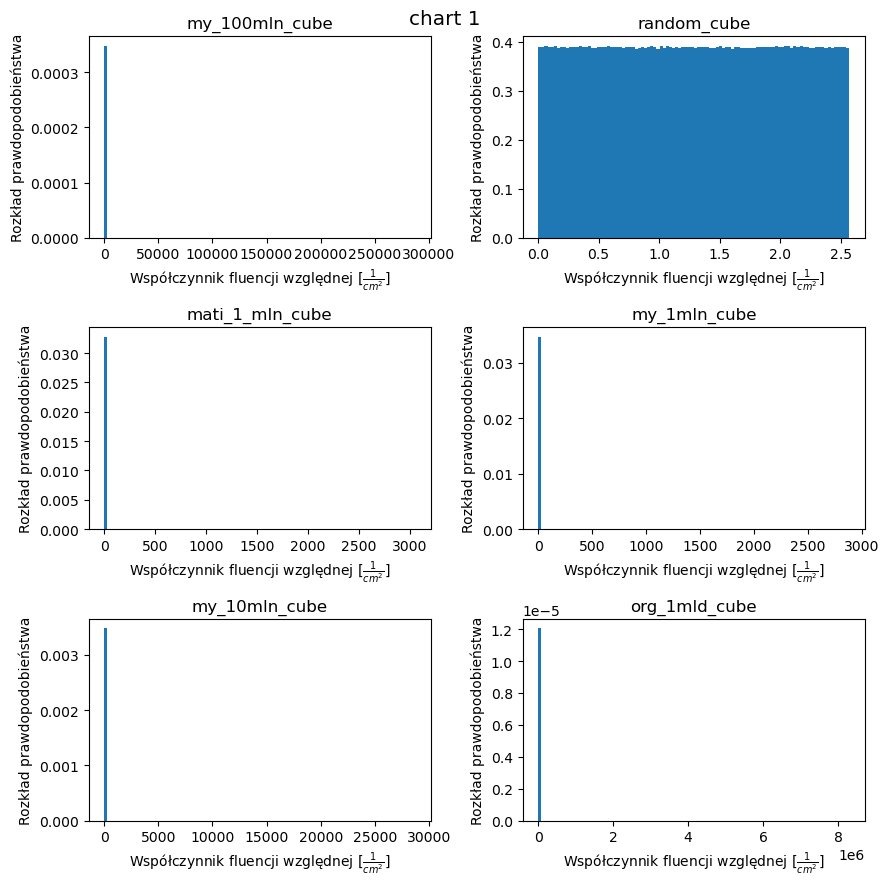

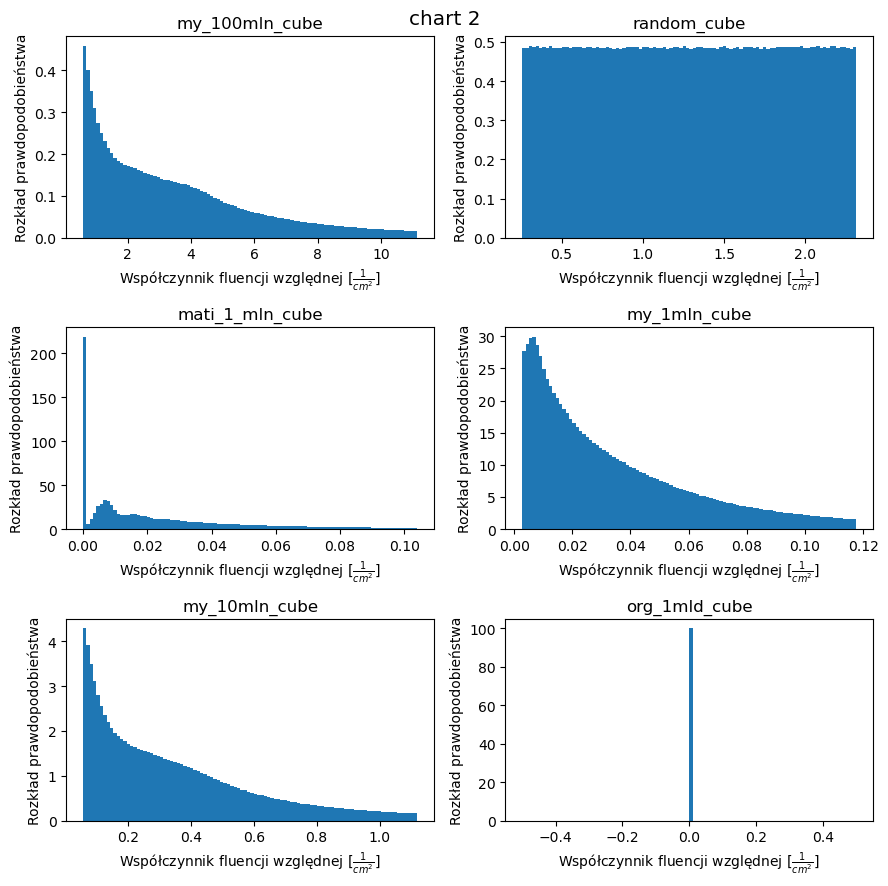

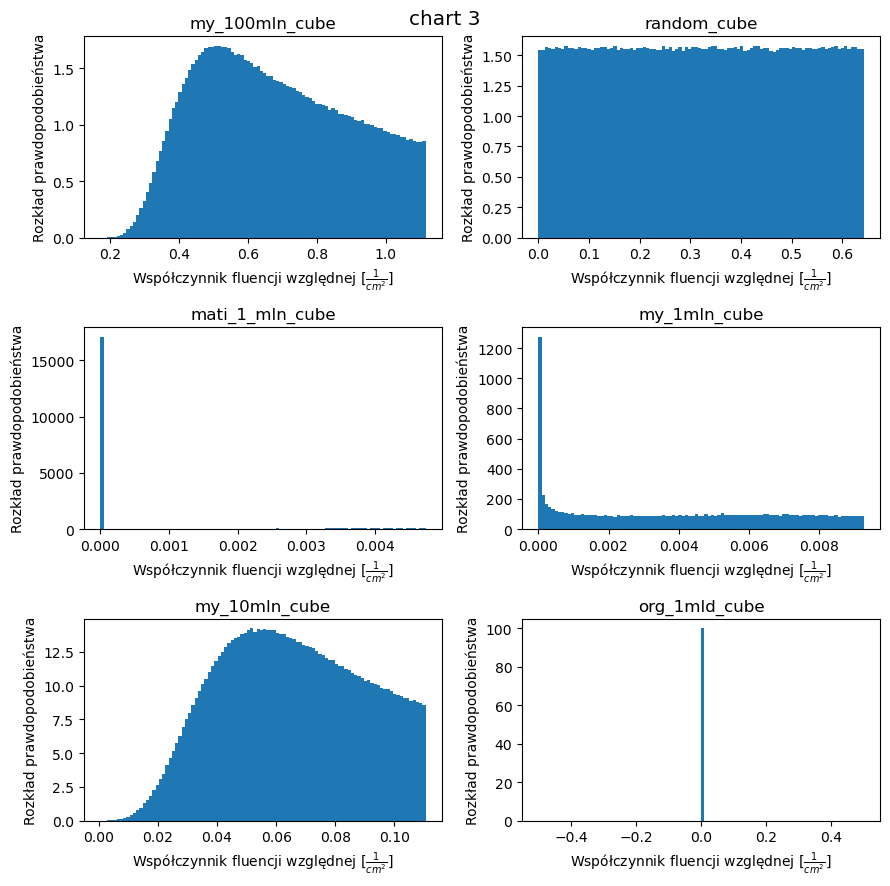

In [11]:
def print_histograms(all_cubes, cub_arr_list=None):
    print()
    i = 1
    l = len(all_cubes)
    
    p_min_list = [0.0 for _ in range(l)]
    p_max_list = [1.0 for _ in range(l)]
    title = f'chart {i}'
    print(title)
    i += 1
    print('min histogram range in quantiles', p_min_list)
    print('max histogram range in quantiles', p_max_list)
    histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    print()
    
    p_min_list = [0.1 for _ in range(l)]
    p_max_list = [0.9 for _ in range(l)]
    title = f'chart {i}'
    print(title)
    i += 1
    print('min histogram range in quantiles', p_min_list)
    print('max histogram range in quantiles', p_max_list)
    histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    print()

    # p_min_list = [0.25 for _ in range(l)]
    # p_max_list = [1.0 for _ in range(l)]
    # title = f'chart {i}'
    # print(title)
    # i += 1
    # print('min histogram range in quantiles', p_min_list)
    # print('max histogram range in quantiles', p_max_list)
    # histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    # print()

    p_min_list = [0.0 for _ in range(l)]
    p_max_list = [0.25 for _ in range(l)]
    title = f'chart {i}'
    print(title)
    i += 1
    print('min histogram range in quantiles', p_min_list)
    print('max histogram range in quantiles', p_max_list)
    histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    print()

    # p_min_list = [0.0 for _ in range(l)]
    # p_max_list = [0.9, 0.01, 0.01, 0.01, 0.9, 0.001]
    # title = f'chart {i}'
    # print(title)
    # i += 1
    # print('min histogram range in quantiles', p_min_list)
    # print('max histogram range in quantiles', p_max_list)
    # histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    # print()

    # p_min_list = [0.05 for _ in range(l)]
    # p_max_list = [1.0 for _ in range(l)]
    # title = f'chart {i}'
    # print(title)
    # i += 1
    # print('min histogram range in quantiles', p_min_list)
    # print('max histogram range in quantiles', p_max_list)
    # histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    # print()

    # p_min_list = [0.05 for _ in range(l)]
    # p_max_list = [0.25 for _ in range(l)]
    # title = f'chart {i}'
    # print(title)
    # i += 1
    # print('min histogram range in quantiles', p_min_list)
    # print('max histogram range in quantiles', p_max_list)
    # histogram(all_cubes, cub_arr_list=cub_arr_list, p_min_list=p_min_list, p_max_list=p_max_list, title=title)
    # print()



print_histograms(all_cubes)

## Normalizacja

normalizacja w *mc321.c*<br>
Fsph = Csph[ir]/Nphotons/shellvolume/mua;
[1/cm2]

In [12]:
def normalization(d):
    if d['normalized_already']:
        print('dane znormalizowano już wcześniej!')
    else:
        # bins_per_1_cm = 120
        # mu_a = 0.37
        # n_photons = 1_000_000
        # val = val * 4.67
        bin_size_in_cm = 1 / d['bins_per_1_cm']
        bin_volume = (bin_size_in_cm)**3
        multi = 1 / (d['n_photons'] * bin_volume * d['mu_a'])
        d['cube'] = d['cube'] * multi
        d['overflow'] = d['overflow'] * multi
        d['photon_weight'] = d['photon_weight'] * multi
        d['normalized_already'] = True



for c in all_cubes:
    normalization(c)

print_stats(all_cubes)

           Name            Sum       Avg             q0          q0_25          q0_50          q0_75             q1            std       variance       Overflow       perc. in      n_photons  non_zero_vals      zero_vals
 my_100mln_cube      2378749.6      0.31           0.01           0.05           0.13           0.26       13422.01          10.07         101.45     2291520.82          50.93      100000000        7776000              0
    random_cube     4670270.27       0.6            0.0            0.3            0.6            0.9            1.2           0.35           0.12            0.0          100.0       10000000        7776000              0
mati_1_mln_cube      2071459.6      0.27            0.0           0.02           0.08           0.22       14260.86          12.04         145.07     2598810.67          44.35        1000000        6191127        1584873
   my_1mln_cube     2379004.49      0.31            0.0           0.04           0.12           0.27       13463.06 


chart 1
min histogram range in quantiles [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max histogram range in quantiles [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

chart 2
min histogram range in quantiles [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
max histogram range in quantiles [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]

chart 3
min histogram range in quantiles [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max histogram range in quantiles [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]



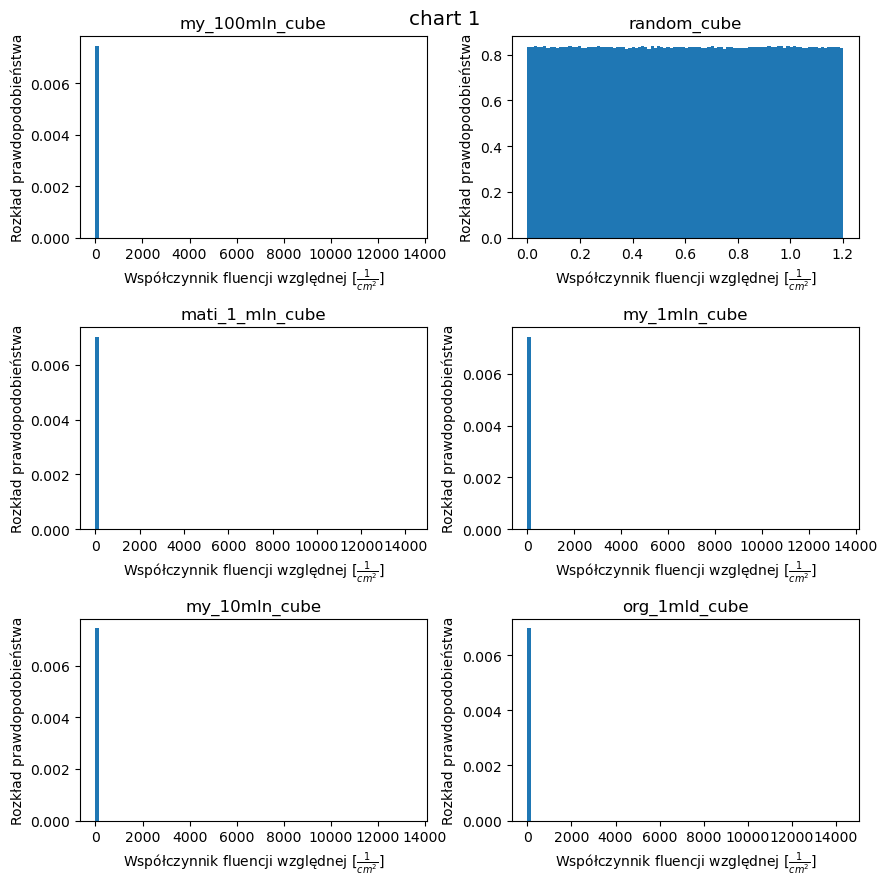

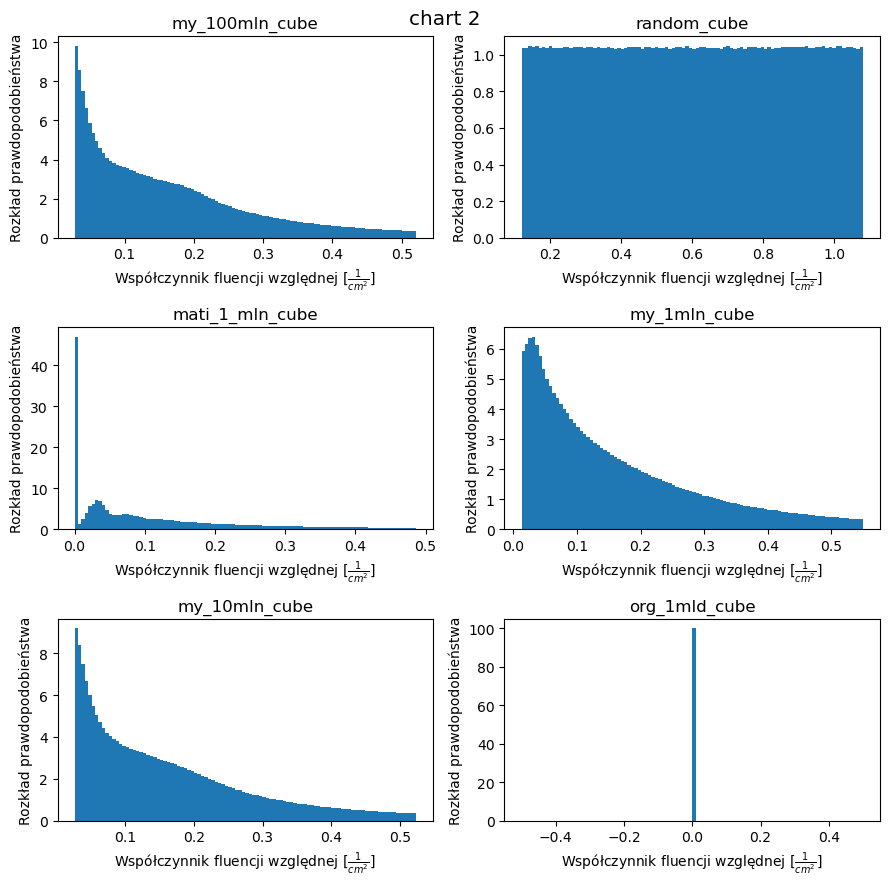

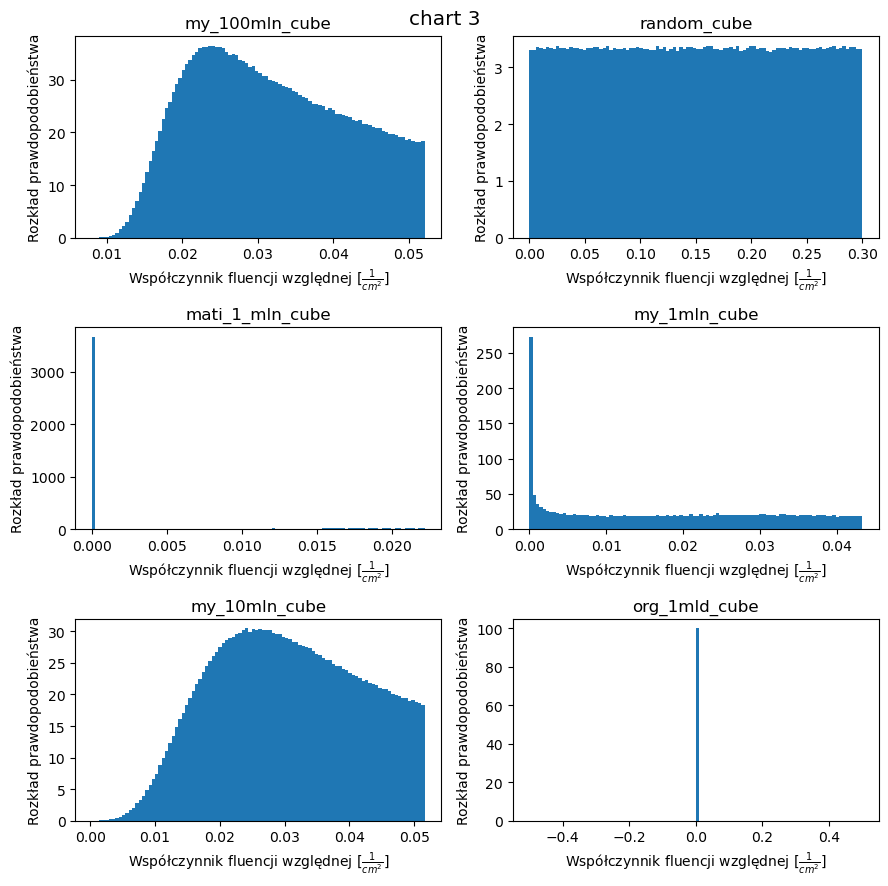

In [13]:
print_histograms(all_cubes)

## Metody porównawcze

<!-- <img src="mati_benchmark_methods2.png" alt="comparing methods" width="900"/> -->
<img src="../mati_benchmark_methods2.png" alt="comparing methods" width="900"/>
<!-- ![comparing methods](mati_benchmark_methods2.png) -->

Dane porównano 5 metodami:
1. cała tabliza 3D, 1:1
2. x_high 2D - obraz sumy wzdłuż 1 osi (osi x) oraz przekroje (slices)
3. z_high 2D - obraz sumy wzdłuż 1 osi (osi z) oraz przekroje (slices)
4. x_high 1D - obraz sumy wzdłuż 2 osi (osi y oraz osi z)
5. z_high 1D - obraz sumy wzdłuż 2 osi (osi y oraz osi z)

### Uniwersalne funkcje porównawcze - niezależne od rzędu wymiarów przestrzennych - 1D, 2D, 3D

In [14]:
def compare2cubes_universal(cub1, cub2, cub_arr1=None, cub_arr2=None):
    name = cub1['name']

    if cub_arr1 is None:
        arr1 = cub1['cube']
    else:
        arr1 = cub_arr1
    if cub_arr2 is None:
        arr2 = cub2['cube']
    else:
        arr2 = cub_arr2

    non_zero_vals1 = np.count_nonzero(arr1)
    non_zero_vals2 = np.count_nonzero(arr2)
    if non_zero_vals1 > 0 and non_zero_vals2 > 0:
        corr = np.corrcoef(arr1.flatten(), arr2.flatten())[0,1]
    else:
        corr = None

    # ------- flatten data histograms -------
    
    # p_min = 0.1
    # p_max = 0.9
    # q1_min = np.quantile(arr1, q=p_min)
    # q1_max = np.quantile(arr1, q=p_max)
    # q2_min = np.quantile(arr2, q=p_min)
    # q2_max = np.quantile(arr2, q=p_max)
    # range1 = (q1_min, q1_max) if q1_min != q1_max else None
    # range2 = (q2_min, q2_max) if q2_min != q2_max else None
    range1 = None
    range2 = None
    bins = 100

    hist1_flat, _ = np.histogram(arr1.flatten(), bins=bins, density=False, range=range1)
    hist2_flat, _ = np.histogram(arr2.flatten(), bins=bins, density=False, range=range2)

    non_zero_vals1 = np.count_nonzero(hist1_flat)
    non_zero_vals2 = np.count_nonzero(hist2_flat)
    if non_zero_vals1 > 0 and non_zero_vals2 > 0:
        corr_hist_flat = np.corrcoef(hist1_flat, hist2_flat)[0,1]
    else:
        corr_hist_flat = None

    # ------- chi-square -------

    # sum_hist1 = hist1_flat.sum()
    # sum_hist2 = hist2_flat.sum()
    # print('sum_hist1', sum_hist1)
    # print('sum_hist2', sum_hist2)
    observed = hist1_flat
    expected = hist2_flat
    chi2_stat, p_value = chisquare(observed, f_exp=expected)
    # Output the chi-square statistic and p-value
    # print(f"Chi-square statistic: {chi2_stat}")
    # print(f"P-value: {p_value}")


    # ------- RMSE -------
    mse = np.square(np.subtract(arr1, arr2)).mean()
    rmse = np.sqrt(mse)


    # ------- print -------
    p1 = f"{name : >15}"
    p2 = f"{corr : >15,.2f}" if corr != None else f"{"-" : >15}"
    p3 = f"{corr_hist_flat : >15,.2f}" if corr_hist_flat != None else f"{"-" : >15}"
    p4 = f"{mse : >15,.2f}{rmse : >15,.2}{chi2_stat : >15,.2}{p_value : >15,.2}"
    p_sum = p1+p2+p3+p4
    print(p_sum)

def compare_all_cubes_universal(other_cub_list, benchmark_cub, other_arr_list=None, benchmark_arr=None):
    print(f"Comparison * to benchmark ({benchmark_cub['name']})")
    print(f"{'name' : >15}{'flat corr' : >15}{'flat hist corr' : >15}{'MSE' : >15}{'RMSE' : >15}{'chi2_stat' : >15}{'chi2 p_value' : >15}")

    for i in range(len(other_cub_list)):
        if other_arr_list is not None:
            other_arr = other_arr_list[i]
        else:
            other_arr = None
        compare2cubes_universal(other_cub_list[i], benchmark_cub, cub_arr1=other_arr, cub_arr2=benchmark_arr)





def corr_table_universal(all_cubes, all_arr=None):
    if all_arr is None:
        flat_arrs = [c['cube'].flatten() for c in all_cubes]
    else:
        flat_arrs = [a.flatten() for a in all_arr]
    print('\ncorrtable of flatten cubes')
    corrtable = np.corrcoef(flat_arrs)
    print(corrtable)

    bins = 100
    hists = [np.histogram(fa.flatten(), bins=bins, density=False)[0] for fa in flat_arrs]
    print('\ncorrtable of histograms')
    corrtable_hist = np.corrcoef(hists)
    print(corrtable_hist)

    print()
    names = [c['name'] for c in all_cubes]
    print(names)





def diff_all_cubes(all_cubes, benchmark_cube):
    diffs = [np.absolute(benchmark_cube['cube'] - c['cube']) for c in all_cubes]
    # benchmark_diff = np.zeros(shape=benchmark_cube['cube'].shape)
    # compare_all_cubes_universal(all_cubes, benchmark_cube, other_arr_list=diffs, benchmark_arr=benchmark_diff)
    # corr_table_universal(all_cubes)
    print_stats(all_cubes, cub_arr_list=diffs)
    print_histograms(all_cubes, cub_arr_list=diffs)

### 1. cała tablica 3D, 1:1

In [15]:
benchmark_cube = all_cubes[0]
compare_all_cubes_universal(all_cubes, benchmark_cube)

Comparison * to benchmark (my_100mln_cube)
           name      flat corr flat hist corr            MSE           RMSE      chi2_stat   chi2 p_value


c:\Users\mateu\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:7985: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


 my_100mln_cube           1.00           1.00           0.00            0.0            nan            nan


c:\Users\mateu\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


    random_cube          -0.00          -0.05         101.66          1e+01            inf            0.0
mati_1_mln_cube           0.95           1.00          17.10            4.1            nan            nan
   my_1mln_cube           1.00           1.00           0.02           0.13            nan            nan
  my_10mln_cube           1.00           1.00           0.00           0.04            nan            nan
  org_1mld_cube           0.41           1.00       1,341.85        3.7e+01            inf            0.0


In [16]:
corr_table_universal(all_cubes)


corrtable of flatten cubes
[[ 1.00000000e+00 -3.89372066e-04  9.45544368e-01  9.99916847e-01
   9.99992178e-01  4.14823371e-01]
 [-3.89372066e-04  1.00000000e+00 -3.73773176e-04 -3.94152528e-04
  -3.89284481e-04  2.11197036e-04]
 [ 9.45544368e-01 -3.73773176e-04  1.00000000e+00  9.45468233e-01
   9.45528400e-01  4.35218001e-01]
 [ 9.99916847e-01 -3.94152528e-04  9.45468233e-01  1.00000000e+00
   9.99924348e-01  4.14511270e-01]
 [ 9.99992178e-01 -3.89284481e-04  9.45528400e-01  9.99924348e-01
   1.00000000e+00  4.14856983e-01]
 [ 4.14823371e-01  2.11197036e-04  4.35218001e-01  4.14511270e-01
   4.14856983e-01  1.00000000e+00]]

corrtable of histograms
[[ 1.         -0.04706149  1.          1.          1.          1.        ]
 [-0.04706149  1.         -0.04706131 -0.04706152 -0.0470615  -0.04706346]
 [ 1.         -0.04706131  1.          1.          1.          1.        ]
 [ 1.         -0.04706152  1.          1.          1.          1.        ]
 [ 1.         -0.0470615   1.          1

#### różnica 3D
abs(A-B)

           Name            Sum       Avg             q0          q0_25          q0_50          q0_75             q1            std       variance       Overflow       perc. in      n_photons  non_zero_vals      zero_vals
 my_100mln_cube            0.0       0.0            0.0            0.0            0.0            0.0            0.0            0.0            0.0     2291520.82            0.0      100000000              0        7776000
    random_cube     4381892.74      0.56            0.0           0.19           0.45           0.76       13421.25          10.07         101.35            0.0          100.0       10000000        7776000              0
mati_1_mln_cube      737539.99      0.09            0.0           0.02           0.05            0.1        7259.82           4.13          17.09     2598810.67          22.11        1000000        7776000              0
   my_1mln_cube      555428.83      0.07            0.0           0.02           0.04           0.09          41.05 

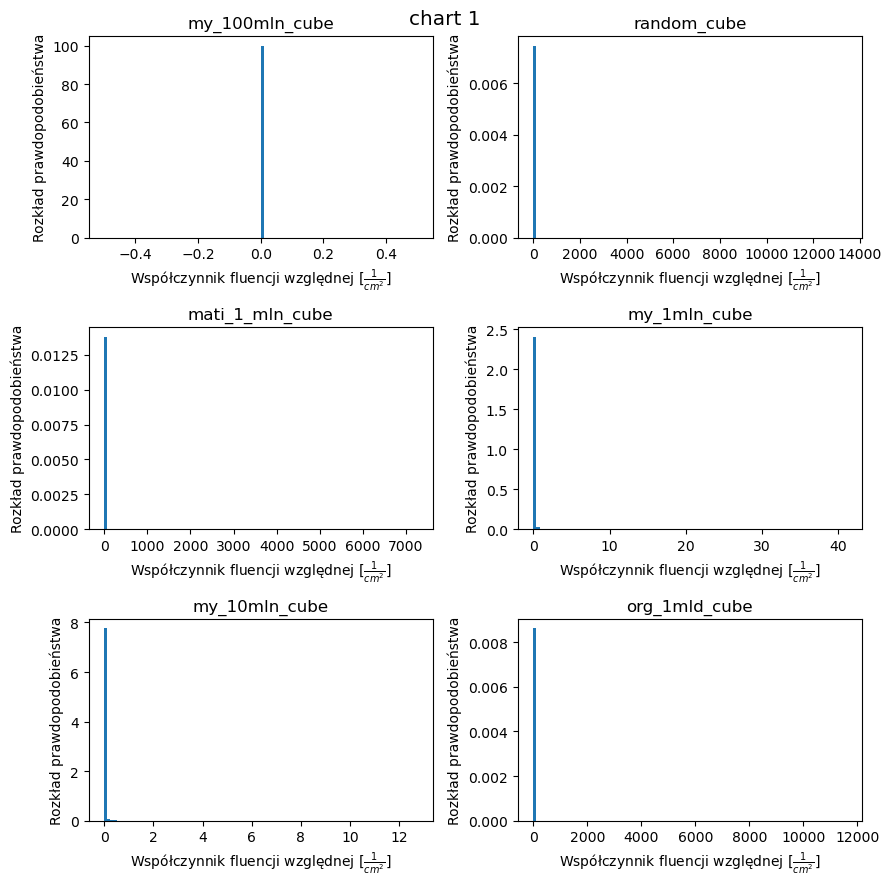

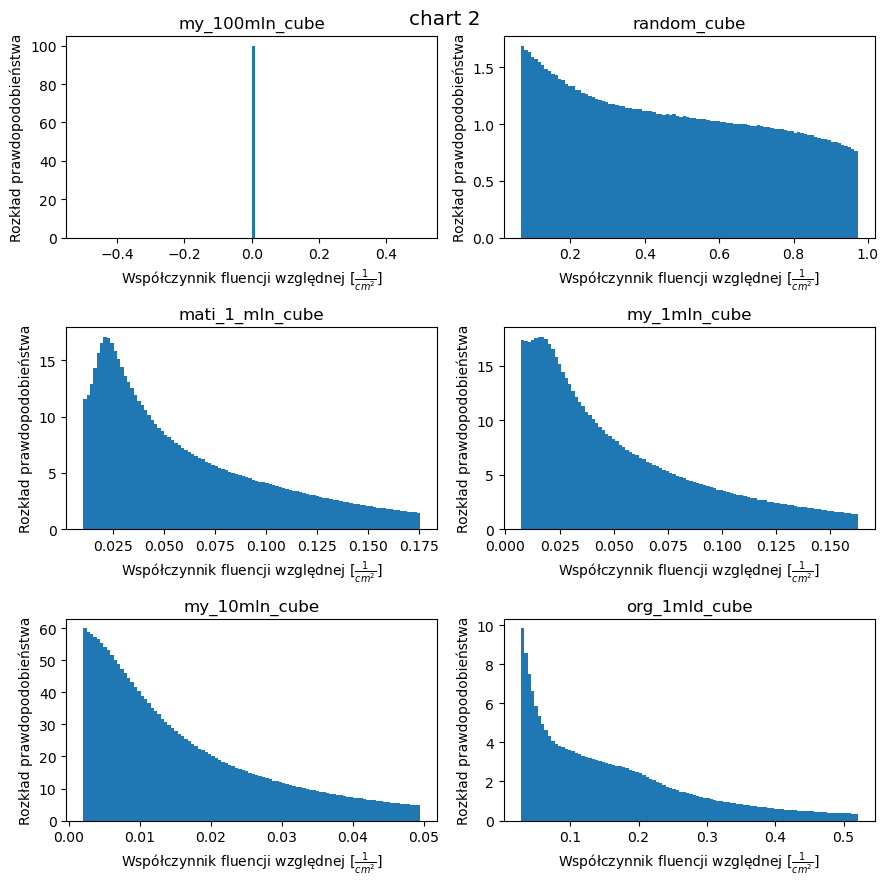

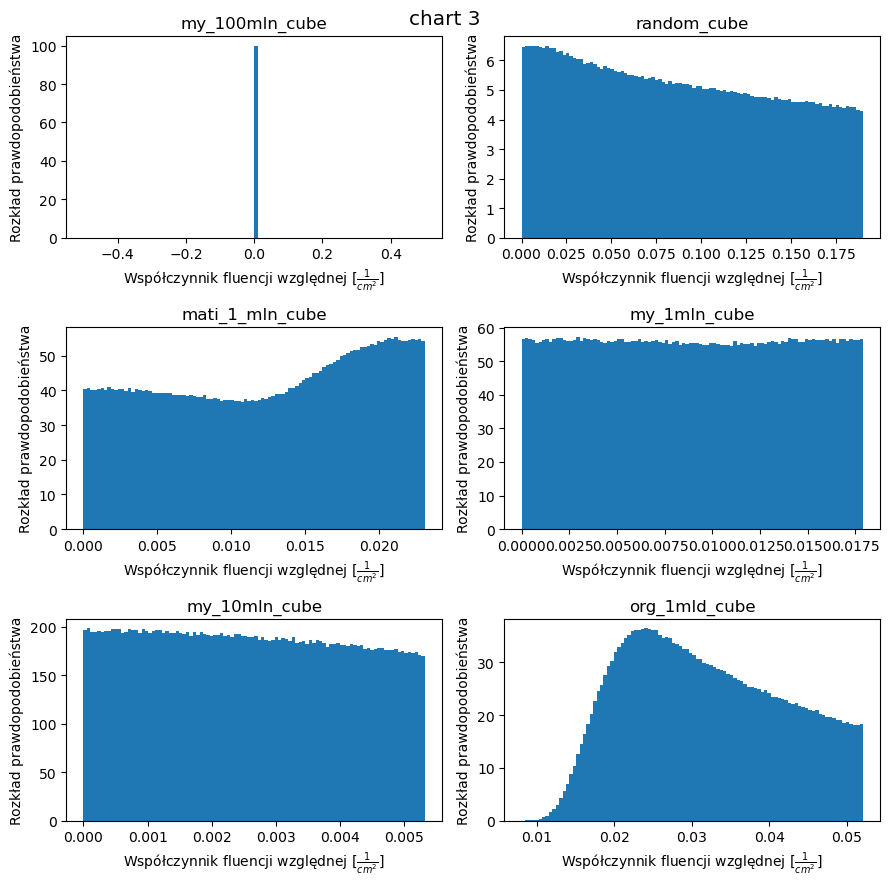

In [17]:
diff_all_cubes(all_cubes, benchmark_cube)

In [18]:
r = all_cubes[0]['cube']
r = np.arange(0,27).reshape((3,3,3))
r_reshaped = r.reshape(-1, 3)
h = np.histogramdd(r_reshaped, bins=(2,2,2), range=None, density=None, weights=None)
h

(array([[[4., 0.],
         [0., 0.]],
 
        [[0., 0.],
         [0., 5.]]]),
 [array([ 0., 12., 24.]), array([ 1., 13., 25.]), array([ 2., 14., 26.])])

In [19]:
all_hists3d = [np.histogramdd(c['cube'].reshape(-1, 3), bins=100, range=None, density=None, weights=None)[0] for c in all_cubes]
benchmark_hist = all_hists3d[0]
compare_all_cubes_universal(all_cubes, benchmark_cube, other_arr_list=all_hists3d, benchmark_arr=benchmark_hist)
corr_table_universal(all_cubes, all_hists3d)

Comparison * to benchmark (my_100mln_cube)
           name      flat corr flat hist corr            MSE           RMSE      chi2_stat   chi2 p_value
 my_100mln_cube           1.00           1.00           0.00            0.0            nan            nan
    random_cube          -0.00           0.16   6,717,675.00        2.6e+03            nan            nan
mati_1_mln_cube           1.00           1.00           0.00          0.039            nan            nan
   my_1mln_cube           1.00           1.00           0.00         0.0098            nan            nan
  my_10mln_cube           1.00           1.00           0.00         0.0051            nan            nan
  org_1mld_cube           1.00           1.00           0.01          0.089            nan            nan

corrtable of flatten cubes
[[ 1.00000000e+00 -9.88549957e-04  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [-9.88549957e-04  1.00000000e+00 -9.88556244e-04 -9.88549860e-04
  -9.88551395e-04 -9

## Slices and sums

<img src="x_high_slices.png" width="300"/>
<img src="x_high_sum.png" width="300"/>
<img src="z_high_slices.png" width="300"/>
<img src="z_high_sum.png" width="300"/>

In [51]:
def make_frames(cub_list, arr_list=None):
    for i in range(len(cub_list)):
        if arr_list is None:
            arr = cub_list[i]['cube']
        else:
            arr = arr_list[i]

        sh = arr.shape
        f = [None for _ in range(20)]

        # --- x_high ---
        # z tej strony wbijamy nóż cięcia slice

        # 3 vertical slices
        f[0] = arr[:,0,:]
        f[1] = arr[:,sh[1]//2,:]
        f[2] = arr[:,-1,:]
        
        # 3 horizontal slices
        f[3] = arr[:,:,-1]
        f[4] = arr[:,:,sh[0]//2]
        f[5] = arr[:,:,0]

        # sums have to be normalized -> division
        # sum y
        f[6] = arr.sum(axis=1) / sh[1]
        # sum z
        f[7] = arr.sum(axis=2) / sh[2]

        # --- z_high ---
        # z tej strony wbijamy nóż cięcia slice

        # 3 vertical slices
        sh = arr.shape
        f[8] = f[0]
        f[9] = f[1]
        f[10] = f[2]
        
        # 3 horizontal slices
        f[11] = arr[0,:,:]
        f[12] = arr[sh[0]//2,:,:]
        f[13] = arr[-1,:,:]

        # sum y
        f[14] = f[6]
        # sum x
        f[15] = arr.sum(axis=0) / sh[0]

        # --- 1D - sum along 2 axes

        # sum xy
        f[16] = arr.sum(axis=(0,1)) / sh[0] / sh[1]
        # sum xz
        f[17] = arr.sum(axis=(0,2)) / sh[0] / sh[2]

        # sum yz
        f[18] = arr.sum(axis=(1,2)) / sh[1] / sh[2]
        # sum xz
        f[19] = f[17]

        # --- save frames ---

        bpc = cub_list[i]['bins_per_1_cm']
        cub_list[i]['frames'] = f
        cub_list[i]['frame_names'] = [
            f"y_low, slice, const y={0: .2f}",
            f"y_low, slice, const y={sh[1]/2/bpc: .2f}",
            f"y_low, slice, const y={sh[1]/bpc: .2f}",

            f"z_high, slice, const z={0.0: .2f}",
            f"z_high, slice, const z={sh[2]/2/bpc: .2f}",
            f"z_high, slice, const z={sh[2]/bpc: .2f}",

            f"y_low\nSuma wzdłuż osi y\n(znormalizowana)",
            f"z_high\nSuma wzdłuż osi z\n(znormalizowana)",

            "",
            "",
            "",

            f"x_high, slice, const x={0.0: .2f}",
            f"x_high, slice, const x={sh[0]/2/bpc: .2f}",
            f"x_high, slice, const x={sh[0]/bpc: .2f}",

            "",
            f"x_high\nSuma wzdłuż osi x\n(znormalizowana)",


            f"Suma wzdłuż osi x oraz y\n(znormalizowana)",
            f"Suma wzdłuż osi x oraz z\n(znormalizowana)",
            f"Suma wzdłuż osi y oraz z\n(znormalizowana)",
            "",
        ]

        cub_list[i]['frame_shortnames'] = [
            "y_low slice",
            "y_low slice",
            "y_low slice",

            "z_high slice",
            "z_high slice",
            "z_high slice",

            "sum_y y_low",
            "sum_z z_high",

            "",
            "",
            "",

            "x_high slice",
            "x_high slice",
            "x_high slice",

            "",
            "x_high z_high",


            f"sum_xy",
            f"sum_xz",
            f"sum_yz",
            "",
        ]






make_frames(all_cubes)

benchmark - najlepsza symulacja


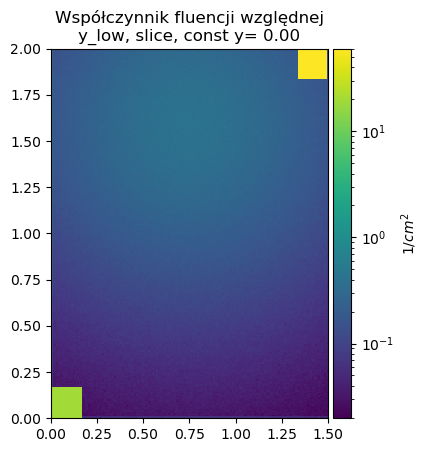

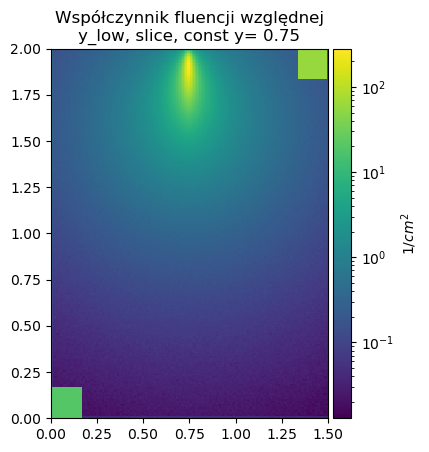

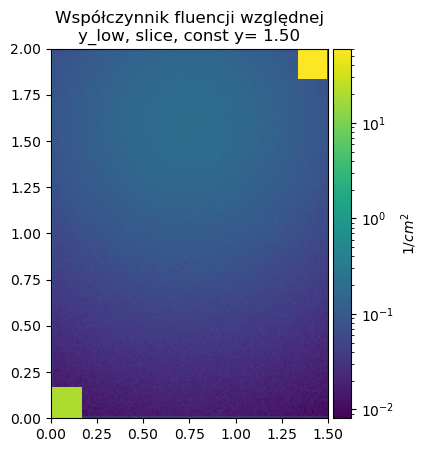

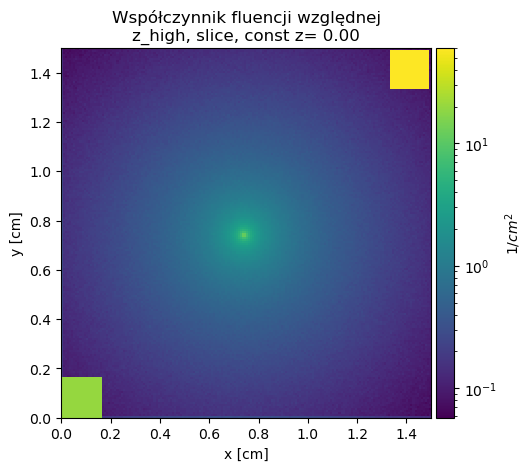

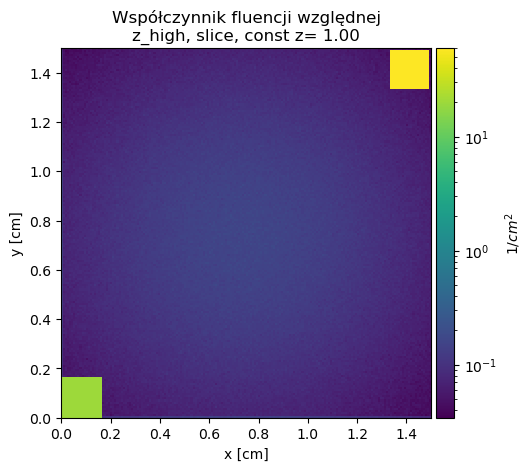

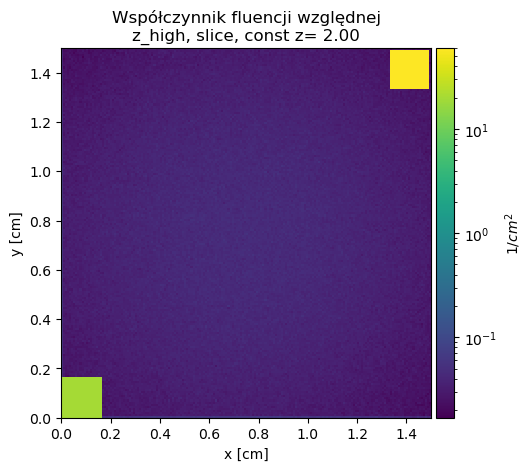

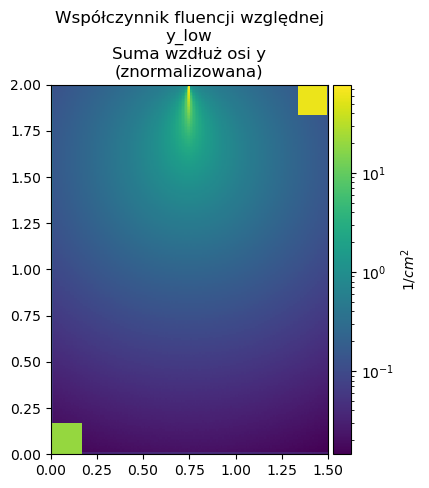

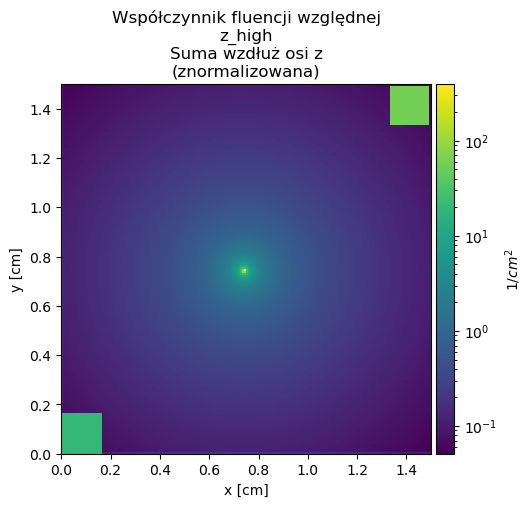

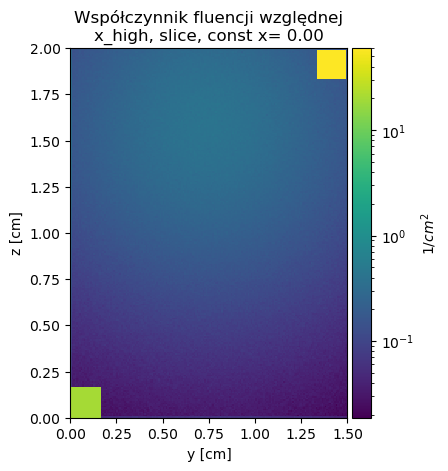

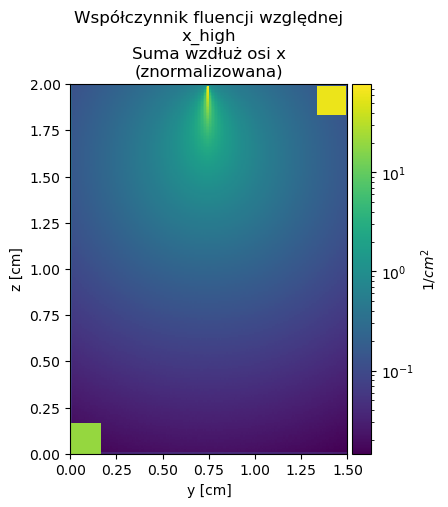

In [52]:
# --- HEAT MAPS ---

def plot2_heatmap2d(arr1: np.ndarray, arr2: np.ndarray, title1=None, title2=None):
    cmap = cm.get_cmap('viridis', 256)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    arrs = [arr1, arr2]
    tits = [title1, title2]
    min_value = np.min( [np.min(arr1), np.min(arr2)] )
    max_value = np.max( [np.max(arr1), np.max(arr2)] )
    for ax, data, tit in zip(axs, arrs, tits):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=min_value, vmax=max_value)
        fig.colorbar(psm, ax=ax)
        ax.set_title(tit)
    plt.show()



# WARNING! if arr it's a sum along axis, remmember to divide by len(of this axis)
# do it before giving it to heatmap2d function
def heatmap2d(arr: np.ndarray, bins_per_cm, title=None, norm="log"):

    # plt.tight_layout()

    # skip first tick on x axis
    # ax = plt.gca()
    # xticks = ax.xaxis.get_major_ticks()
    # xticks[0].label1.set_visible(False)

    extent=[0, arr.shape[0]/bins_per_cm, 0, arr.shape[1]/bins_per_cm] # podziałka legendy
    
    # blok tytułów, nagłówków
    xlab = ""
    ylab = ""
    title2 = "Współczynnik fluencji względnej"
    title2 += "\n" + title if title is not None else ""
    if "x_high" in title2:
        xlab = "y [cm]"
        ylab = "z [cm]"
    if "y_high" in title2:
        xlab = "x [cm]"
        ylab = "z [cm]"
    if "z_high" in title2:
        xlab = "x [cm]"
        ylab = "y [cm]"
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title2)

    # obracanie tablicy i wyświetlenie tablicy
    plot_arr = np.flip(arr.transpose(), axis=(0))
    plt.imshow(plot_arr, cmap='viridis', norm=norm, interpolation="none", extent=extent) # musi być przed color bar

    # kolorowy pasek ze skalą
    # cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb = plt.colorbar(pad=0.010)
    cb.set_label(r'$ 1/cm^2 $')

    # manager = plt.get_current_fig_manager()
    # manager.window.showMaximized()
    # manager.canvas.toolbar.save_figure()

    plt.show()





def print_all_frames(all_cubes, frame_ids=None):
    frame_ids = list(range(0,8))+[11,15] if frame_ids is None else frame_ids
    for c in range(len(all_cubes)):
        for i in frame_ids:
            bins_per_cm = all_cubes[0]['bins_per_1_cm']
            title = all_cubes[0]['frame_names'][i]
            arr = all_cubes[0]['frames'][i]
            arr2 = all_cubes[c]['frames'][i]
            arr1 = arr

            # check axis
            arr1 = arr1.copy()
            arr1[0:20, 0:20] = 20 # niskie wartości, początek (0,0)
            arr1[-20:-1, -20:-1] = 60 # wysokie wartości, koniec (1.5, 2.0)

            heatmap2d(arr1, bins_per_cm, title=title)
            # plot2_heatmap2d(arr1, arr2, title1=None, title2=None)



print("benchmark - najlepsza symulacja")
best_cube_list = [cube for cube in all_cubes if 'benchmark' in cube['name']]
print_all_frames(all_cubes[0:1])

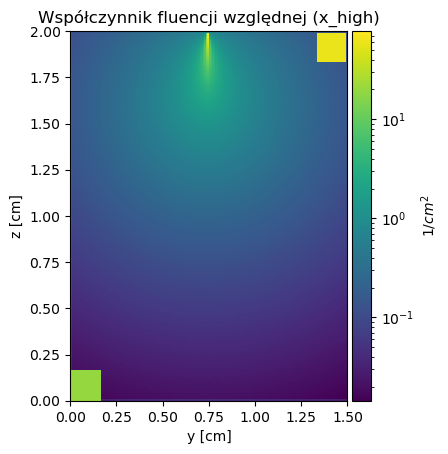

In [102]:
c = 2
i = 6
bins_per_cm = all_cubes[0]['bins_per_1_cm']
title = all_cubes[0]['frame_shortnames'][i]
arr = all_cubes[0]['frames'][i]
arr2 = all_cubes[c]['frames'][i]
arr1 = arr

# check axis
arr = arr.copy()
arr[0:20, 0:20] = 20 # niskie wartości, początek (0,0)
arr[-20:-1, -20:-1] = 60 # wysokie wartości, koniec (1.5, 2.0)

heatmap2d(arr, bins_per_cm, title=title)
# plot2_heatmap2d(arr1, arr2, title1=None, title2=None)

### 2. x_high 2D - obraz sumy wzdłuż 1 osi (osi x) oraz przekroje (slices)

### 3. z_high 2D - obraz sumy wzdłuż 1 osi (osi z) oraz przekroje (slices)

### 4. x_high 1D - obraz sumy wzdłuż 2 osi (osi y oraz osi z)

### 5. z_high 1D - obraz sumy wzdłuż 2 osi (osi y oraz osi z)

In [ ]:




show_frames









NOTEBOOK porównywanie dwóch ze sobą
    3 metody z obrazka
        porównać wizualnie
        porównać wartości
        miary statystyczne

    plot czasówek
    plot jak zmieniają się miary wraz z wzrostem photons

